# Проект: Определение стоимости автомобилей

[yandex_practicum](https://practicum.yandex.ru/learn/data-scientist/courses/690358eb-b995-45f6-bde0-6260f7ad4df8/sprints/176084/topics/d3e1f0bf-daa2-4d7b-99a2-c958bfe85f28/lessons/c80a240f-f88a-48a6-b0d0-5839385a1c86/)

Описание проекта:

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. 

Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать <font color='red'>количество заказов </font>такси на следующий час. Постройте модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.



## Описание данных

Признаки



Целевой признак
- 'num_orders' (от англ. number of orders, «число заказов»).



## 1.  Подготовка данных



### 1.1 Загружаем библиотеки и читаем данные


In [2]:

# библиотеки для работы с данными
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math

# библиотека для оценки корреляции
from phik import phik_matrix


# бибилотеки для подготовки данных
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import (StandardScaler, 
                                   MinMaxScaler, 
                                   RobustScaler,
                                   PolynomialFeatures, 
                                   OneHotEncoder,
                                   OrdinalEncoder, 
                                   LabelEncoder)

from sklearn.feature_selection import SelectKBest, f_classif
#from imblearn.over_sampling import SMOTE


# библиотеки для пайплайнов
# класс ColumnTransformer помогает работать с данными разного типа в одном наборе
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


# класс для работы с пропусками
from sklearn.impute import SimpleImputer

# библиотеки для линейной регрессии
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error ,mean_absolute_error, r2_score, make_scorer, root_mean_squared_error

# библиотеки для градиентного бустинга
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor



# библиотека решающих деревьев
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor


# бибилиотека для графика ROC-кривой и расчёта ROC-AUC
#from sklearn.metrics import roc_auc_score, RocCurveDisplay



# добавим библиотеку для построения scatter диаграмм рассеяния с тренд-линиями
#import plotly.express as px 
#import plotly.graph_objects as go



In [3]:

try:
    data = pd.read_csv('/datasets/taxi.csv')
except FileNotFoundError:
    data = pd.read_csv('/Users/tony_builder/Documents/GitHub/studying/yandex_practicum/13_time_series/data/taxi.csv')

data.head()


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Пустых значений нет, а вот данные в столбце datetime нужно перевести в одноименный тип данных

In [6]:
data['ts'] = data.datetime.astype('datetime64')

In [7]:
data.drop('datetime', axis=1, inplace=True)

In [8]:
data.head()

,num_orders,ts
0,9,2018-03-01 00:00:00
1,14,2018-03-01 00:10:00
2,28,2018-03-01 00:20:00
3,20,2018-03-01 00:30:00
4,32,2018-03-01 00:40:00


In [13]:
temp_df = data.copy()

temp_df['year'] = temp_df.ts.dt.year

temp_df['month'] = temp_df.ts.dt.month

temp_df['day'] = temp_df.ts.dt.day

temp_df['hour'] = temp_df.ts.dt.hour

temp_df['minute'] = temp_df.ts.dt.minute

temp_df.head()

,num_orders,ts,year,month,day,hour,minute
0,9,2018-03-01 00:00:00,2018,3,1,0,0
1,14,2018-03-01 00:10:00,2018,3,1,0,10
2,28,2018-03-01 00:20:00,2018,3,1,0,20
3,20,2018-03-01 00:30:00,2018,3,1,0,30
4,32,2018-03-01 00:40:00,2018,3,1,0,40


In [14]:
for col in temp_df.drop(['num_orders', 'ts'], axis=1).columns:
    print(f'{col}, число уникальных значений {temp_df[col].nunique()}')
    print(temp_df[col].unique())
    print()

year, число уникальных значений 1
[2018]

month, число уникальных значений 6
[3 4 5 6 7 8]

day, число уникальных значений 31
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]

hour, число уникальных значений 24
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]

minute, число уникальных значений 6
[ 0 10 20 30 40 50]



Судя по всему, в столбце ts стоят временные метки числа заказов за 2018 год с марта по август <font color='red'> каждые 10 минут  </font>

Установим столбец ts в качестве индексов


In [15]:

data.set_index('ts', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим верность хронологии индексов (временного ряда)

Чтобы проверить, в хронологическом ли порядке расположены даты и время, посмотрите атрибут индекса таблицы is_monotonic (англ. «монотонный»). Если порядок соблюдён, атрибут вернёт True, если нет — False.

Отсортируйте индекс таблицы. 

In [18]:
data = data.sort_index()

print(data.index.is_monotonic_increasing)


True


In [19]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


<AxesSubplot: xlabel='ts'>

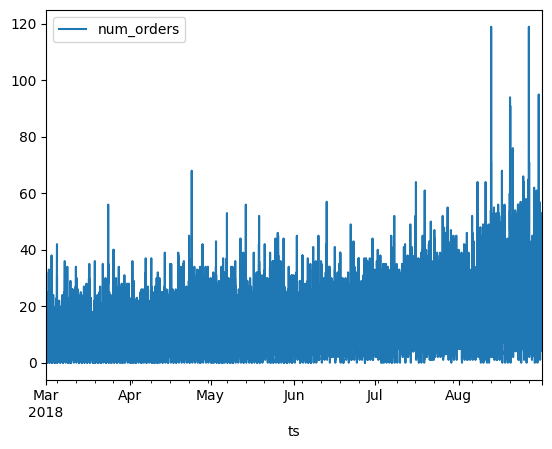

In [20]:
data.plot()

### 1.2 Ресэмплирование